# ADNI Feature Attribution

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import nibabel as nib
import os
import os.path as osp
import glob
import captum
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold, train_test_split
from captum.attr import IntegratedGradients, LRP, LayerGradCam, LayerAttribution, Occlusion, DeepLiftShap, GuidedBackprop, InputXGradient

from tqdm.notebook import tqdm, trange

from model import *
from data import *
from plotutils import *

In [2]:
FIGURES_PATH = "figures"
os.makedirs(FIGURES_PATH, exist_ok=True)

AM_PATH = osp.join(DATA_PATH, "attributions")
os.makedirs(AM_PATH, exist_ok=True)

In [3]:
torch.manual_seed(19)

In [4]:
adni_net = AdniNet()
adni_net.load_state_dict(torch.load(osp.join(MODEL_PATH, "kfold-1.pt")))
adni_net.eval()

AdniNet(
  (cb1): ConvBlock(
    (conv3d): Conv3d(1, 5, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (batchnorm): BatchNorm3d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool3d): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (cb2): ConvBlock(
    (conv3d): Conv3d(5, 5, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (batchnorm): BatchNorm3d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool3d): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (cb3): ConvBlock(
    (conv3d): Conv3d(5, 5, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (batchnorm): BatchNorm3d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool3d): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (linear1): Linear(in_features=10800, out_featur

In [5]:
# Softmax-Proxy
softmax_net = nn.Sequential(adni_net, nn.Softmax(1))
softmax_net.eval()
adni_net.eval()

AdniNet(
  (cb1): ConvBlock(
    (conv3d): Conv3d(1, 5, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (batchnorm): BatchNorm3d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool3d): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (cb2): ConvBlock(
    (conv3d): Conv3d(5, 5, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (batchnorm): BatchNorm3d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool3d): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (cb3): ConvBlock(
    (conv3d): Conv3d(5, 5, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (batchnorm): BatchNorm3d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool3d): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (linear1): Linear(in_features=10800, out_featur

In [6]:
cn_files = glob.glob(osp.join(DATA_PATH, "CN", "*.nii.gz"))
print("Found {} CN files.".format(len(cn_files)))

ad_files = glob.glob(osp.join(DATA_PATH, "AD", "*.nii.gz"))
print("Found {} AD files.".format(len(ad_files)))

f_ds = np.array(cn_files + ad_files)

Found 254 CN files.
Found 189 AD files.


In [7]:
X = load_nifti(f_ds, transform=crop)
Y = torch.tensor([0] * len(cn_files) + [1] * len(ad_files))

In [8]:
# load train and test indices from best fold
train_idxs, test_idxs = torch.load(osp.join(MODEL_PATH, "idxs-1.pt"))

In [9]:
X_train, X_test = X[train_idxs], X[test_idxs]
Y_train, Y_test = Y[train_idxs], Y[test_idxs]
# train_test_split(X, Y, train_size=0.8, shuffle=True, stratify=Y, random_state=19)

# compute dataset mean and sigma for standardization
MU = X_train.mean()
SIGMA = X_train.std()

tf_train = Compose([Normalize(MU, SIGMA), augment])
tf_test = Compose([Normalize(MU, SIGMA)])

train_ds = TransformTensorDataset(X_train, Y_train, transform=tf_train)
test_ds = TransformTensorDataset(X_test, Y_test, transform=tf_test)

test_loader = DataLoader(test_ds, shuffle=True)

In [10]:
# if everything was loaded correctly, should output an accuracy > 0.8
correct = 0
for (x,y) in test_loader:
    correct += (adni_net(x).argmax(1) == y).sum()
print(correct.item() / len(test_ds))

0.8764044943820225


# Class Means and Variances

In [11]:
mu = X_train.mean(0)
sigma = X_train.std(0)

mu_ad = X_train[Y_train == 1].mean(0)
mu_cn = X_train[Y_train == 0].mean(0)

sigma_ad = X_train[Y_train == 1].std(0)
sigma_cn = X_train[Y_train == 0].std(0)

diff = mu_ad - mu_cn

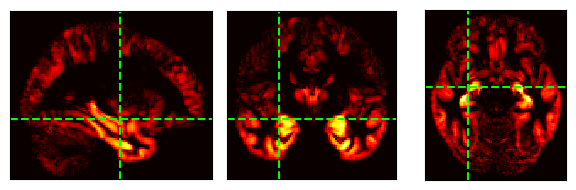

In [12]:
plot_slices(diff.squeeze().abs(), 30, 65, 35, cmap="hot")
plt.show()

## Feature Attributions

In [13]:
from captum.attr import Occlusion, Deconvolution, Saliency, GuidedBackprop
from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import InputXGradient, LRP
from captum.attr import IntegratedGradients, DeepLift, DeepLiftShap

In [14]:
base = torch.zeros(1,1,100,120,100)
random = base + torch.normal(0, 1, (20, 1, 100, 120, 100))

# define methods and params
grad_cam_params = {"relu_attributions": False}

METHODS = [
    # (Name, Captum Class, Additional Parameters)
    ("Occlusion", Occlusion(adni_net), {"baselines": base, "sliding_window_shapes": (1,20,20,20), "strides": 10}),
    ("Deconvolution", Deconvolution(adni_net), {}),
    ("Saliency", Saliency(adni_net), {"abs": False}), # has keyword abs, if False returns the signed Gradient
    ("backprop", GuidedBackprop(adni_net), {}),
    ("Grad-CAM", LayerGradCam(softmax_net, adni_net.cb3.conv3d), grad_cam_params),
    ("InputXGradient", InputXGradient(adni_net), {}),
    ("LRP", LRP(adni_net), {}),
    ("IG", IntegratedGradients(adni_net), {"baselines": base}),
    ("DeepLIFT", DeepLift(adni_net), {"baselines": base}),
    ("DeepSHAP", DeepLiftShap(adni_net), {"baselines": random}),
]

In [15]:
def multi_attribute(methods, x, target, interpolation=None):
    """Computes feature attributions for each (name, captum object, params) in methods."""
    attribs = {}    
    for name, method, params in tqdm(methods):
        attr = method.attribute(x, target=target, **params)
        if attr.shape != x.shape and interpolation is not None:
            # interpolate Grad-CAM Attribution
            attr = LayerAttribution.interpolate(attr, interpolation)
        attribs[name] = attr.detach()
    return attribs

In [16]:
from captum.attr._utils.lrp_rules import EpsilonRule

def add_hooks(model):
    """Add missing LRP hooks, that Captum didn't define."""
    model.cb1.conv3d.rule =  EpsilonRule()
    model.cb1.batchnorm.rule =  EpsilonRule()
    model.cb2.conv3d.rule =  EpsilonRule()
    model.cb2.batchnorm.rule =  EpsilonRule()
    model.cb3.conv3d.rule =  EpsilonRule()
    model.cb3.batchnorm.rule =  EpsilonRule()

In [17]:
# compute attributions for the test set
# this may take a while... please don't turn the gameboy off

grad_cam_params["relu_attributions"] = False

for i, (x, label) in enumerate(tqdm(test_ds)):
    for target in range(2):
        add_hooks(adni_net)
        am = multi_attribute(METHODS, x.unsqueeze(0), target, interpolation=(100, 120, 100))
        fname = osp.join(AM_PATH, "idx-{}_target-{}.p".format(i, target))
        torch.save(am, fname)

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/home/bh282/.local/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/bh282/.local/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/bh282/.local/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

# Mean Feature Attribution

In [18]:
mean_ams = { name: torch.zeros(1,1,100,120,100) for name, _, _ in METHODS}
n = 0

for i, (x, label) in enumerate(tqdm(test_ds)):
    if label == 0:
        continue
    ams_name = osp.join(AM_PATH, "idx-{}_target-1.p".format(i))
    ams = torch.load(ams_name)
    for key, am in ams.items():
        #am = F.relu(am)
        am = am.abs()
        mean_ams[key] += am
    n += 1

for key in mean_ams.keys():
    mean_ams[key] /= n
print(n)

  0%|          | 0/89 [00:00<?, ?it/s]

38


In [19]:
mu_ad_test = X_test[Y_test == 1].mean(0)

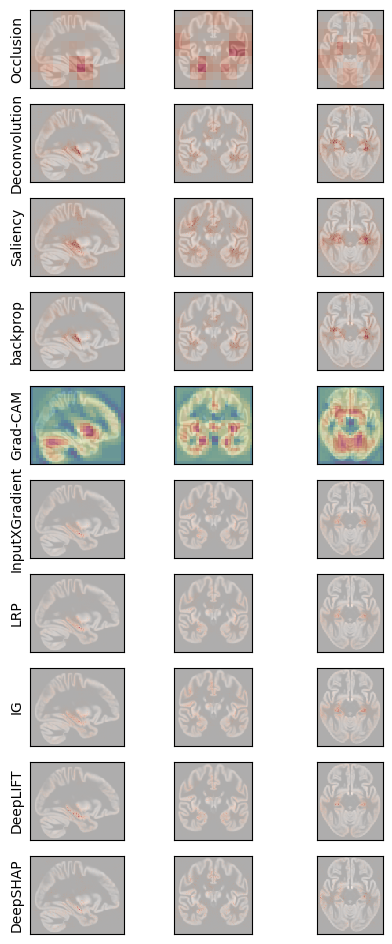

In [22]:
plot_attributions(mu_ad_test, mean_ams, mean_ams.keys(), 30, 65, 35)

In [20]:
def plot_row(axs, bg, am, cmap, norm, slices):
    """Plots a row of attribution maps."""
    x,y,z = slices
    lines = [(y,z), (x,z), (x,y)]
    axs[1].set_anchor("E")
    vmax = max(am[x,:,:].max(), am[:,y,:].max(), am[:,:,z].max())
    for i, s in enumerate(slices):
        a = np.rollaxis(np.array(am), i, 0)
        b = np.rollaxis(np.array(bg), i, 0)
        axs[i].imshow(b[s,:,:].T, origin="lower", cmap="gray")
        im = axs[i].imshow(a[s, :, :].T, origin="lower", vmin=0, vmax=vmax, cmap=cmap, alpha=0.5)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].axvline(x=lines[i][0], linestyle=":", color="w", alpha=0.3)
        axs[i].axhline(y=lines[i][1], linestyle=":", color="w", alpha=0.3)
    
    plt.colorbar(im, ax=axs, pad=0.01)

def plot_amgrid(x, ams, fams, cmap="Spectral_r", norm=None):
    fig, axs = plt.subplots(len(fams),3, figsize=(7,2*len(fams)), width_ratios=(720,600,500))
    plt.subplots_adjust(wspace=0.15, hspace=0.15)

    for i, fam in enumerate(fams):
        axs[i,0].set_ylabel(fam)
        am = mean_ams[fam]
        plot_row(axs[i], mu_ad_test.squeeze(), am.squeeze(), "Spectral_r", norm, [35,55,35])

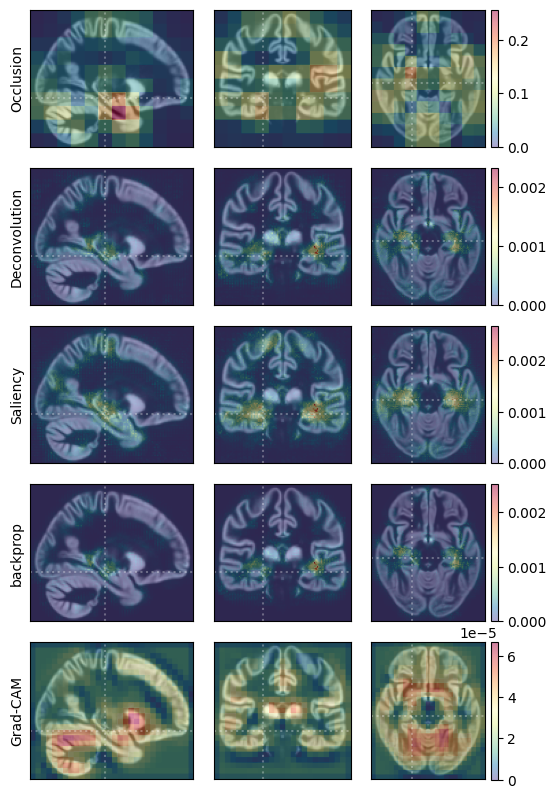

In [21]:
plot_amgrid(mu_ad_test.squeeze(), mean_ams, ["Occlusion", "Deconvolution", "Saliency", "backprop", "Grad-CAM"])
plt.savefig(osp.join(FIGURES_PATH, "mean_ams_1.png"), transparent=True, bbox_inches="tight")
plt.show()

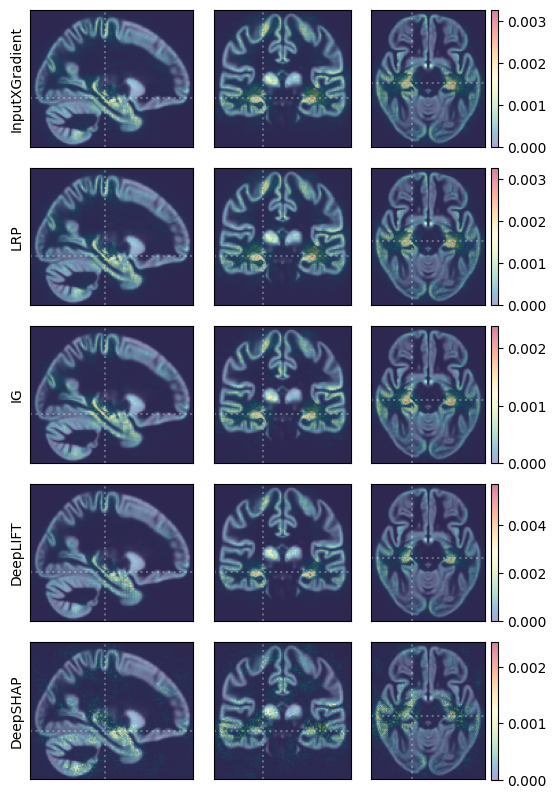

In [23]:
plot_amgrid(mu_ad_test.squeeze(), mean_ams, ['InputXGradient', 'LRP', 'IG', 'DeepLIFT', 'DeepSHAP'])
plt.savefig(osp.join(FIGURES_PATH, "mean_ams_2.png"), transparent=True, bbox_inches="tight")

In [227]:
def save_attributions(path, data, attribs, x, y, z, axlines=True):
    os.makedirs(path, exist_ok=True)
    n = len(METHODS)
    axlines = [(y,z), (x,z), (x,y)]
    for i, (name, _, _) in enumerate(METHODS):
        norm = None if name == "Grad-CAM" else CenteredNorm()
        for j, (v, al) in enumerate(zip([x,y,z], axlines)):
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            ax.axis(False)
            plot_slice(data.squeeze(), j, v, ax=ax, alpha=0.5)
            plot_overlay(ax, attribs[name].squeeze(), j, v, alpha=0.5, norm=norm)
            if axlines:
                ax.axvline(x=al[0], linestyle="--", color="lime")
                ax.axhline(y=al[1], linestyle="--", color="lime")
            plt.savefig(osp.join(path, "{}_{}.png".format(name, j)))

# Compare Attributions

In [24]:
# Epsilon to avoid division by zero and floating point drift
EPSILON = 1e-5

def compute_z(x, mu, sigma, mask_small_sigma=True):
    d = x - mu
    # work around for floating point shenanigans
    # otherwise, d will be really small sometimes where it should be 0
    d[d.abs() < EPSILON] = 0
    z = d / (sigma + EPSILON)
    # yet another workaround, otherwise outliers have still huge values
    if mask_small_sigma:
        mask = sigma <= 0.01
        z[mask.view(z.shape)] = 0
    return z

### 1. Correlation

In [25]:
def load_attrib(idx, target):
    attrib_fname = osp.join(AM_PATH, "idx-{}_target-{}.p".format(idx, target))
    return torch.load(attrib_fname)

In [26]:
import pandas as pd
import seaborn as sns

def plot_corr(corr, vmin=None):
    sns.set_style("white")

    dfnames = [name for name, _,_ in METHODS] + ["random", "z-score"]
    dfnames_ridx = dfnames[-2:] + dfnames[:-2]

    df = pd.DataFrame(corr, columns=dfnames, index=dfnames)
    df=df.reindex(dfnames_ridx, columns=dfnames_ridx)
    
    f, ax = plt.subplots(figsize=(12, 12))
    #cmap = sns.diverging_palette(220, 10, as_cmap=True)
    mask = np.zeros_like(df)
    mask[np.triu_indices_from(mask)] = True

    ax = sns.heatmap(df, mask=mask, vmin=vmin, vmax=1, center=0, cmap="seismic", square=True, linewidths=.5, cbar_kws={"shrink": .5})
    return ax

In [27]:
from scipy.stats import spearmanr
# spearmanr probably better suited than pearson correlation coefficient
# checks for monotonic, instead of just linear relationship
# for example, pearson correlation changes after applying log

# however, linear correlation is probably more interesting

# compute z-score against other class
mu_class = [mu_ad, mu_cn]
sigma_class = [sigma_ad, sigma_cn]
corr = [0, 0]

for idx, (x,y) in enumerate(tqdm(test_ds)):
    for target in range(2):
        z = compute_z(x, mu_class[target], sigma_class[target])
        ams = load_attrib(idx, target)
        ams["z-score"] = z.unsqueeze(0)
        ams["random"] = torch.normal(0,1,x.shape)
        flattened = [am.flatten().detach().numpy() for name, am in ams.items()]
        corr[target] += np.corrcoef(np.array(flattened))
        #corr[target] += spearmanr(np.array(flattened), axis=1).statistic
corr = np.array(corr)
corr /= len(test_ds)

  0%|          | 0/89 [00:00<?, ?it/s]

In [28]:
pcorr = (corr[0] + corr[1]) / 2

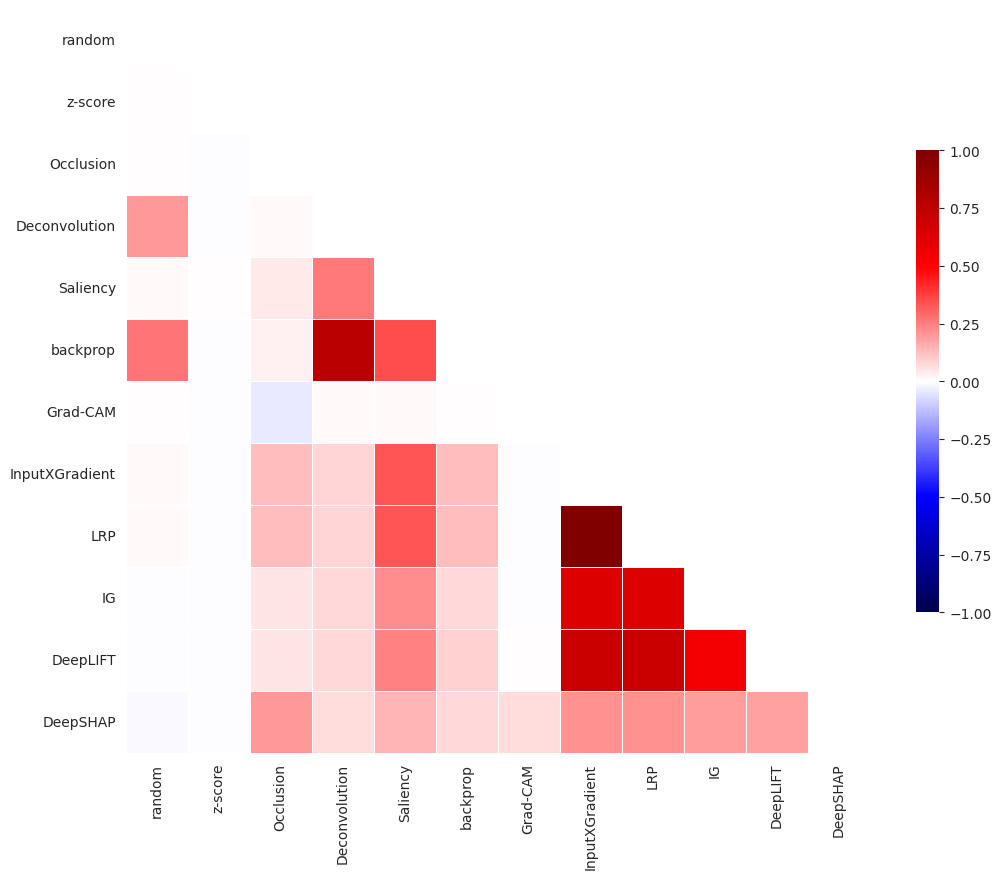

In [29]:
ax = plot_corr(pcorr, vmin=-1)
plt.savefig(osp.join(FIGURES_PATH, "pcorr.png"), transparent=True, bbox_inches="tight")
plt.show()

In [30]:
# compute z-score against other class
mu_class = [mu_ad, mu_cn]
sigma_class = [sigma_ad, sigma_cn]
corr = [0, 0]

for idx, (x,y) in enumerate(tqdm(test_ds)):
    for target in range(2):
        z = compute_z(x, mu_class[target], sigma_class[target]).abs()
        ams = load_attrib(idx, target)
        ams["z-score"] = z.unsqueeze(0).abs()
        ams["random"] = torch.normal(0,1,x.shape).abs()
        flattened = [am.abs().flatten().detach().numpy() for name, am in ams.items()]
        corr[target] += np.corrcoef(np.array(flattened))
        #corr[target] += spearmanr(np.array(flattened), axis=1).statistic
corr = np.array(corr)
corr /= len(test_ds)

  0%|          | 0/89 [00:00<?, ?it/s]

In [31]:
abs_pcorr = (corr[0] + corr[1]) / 2

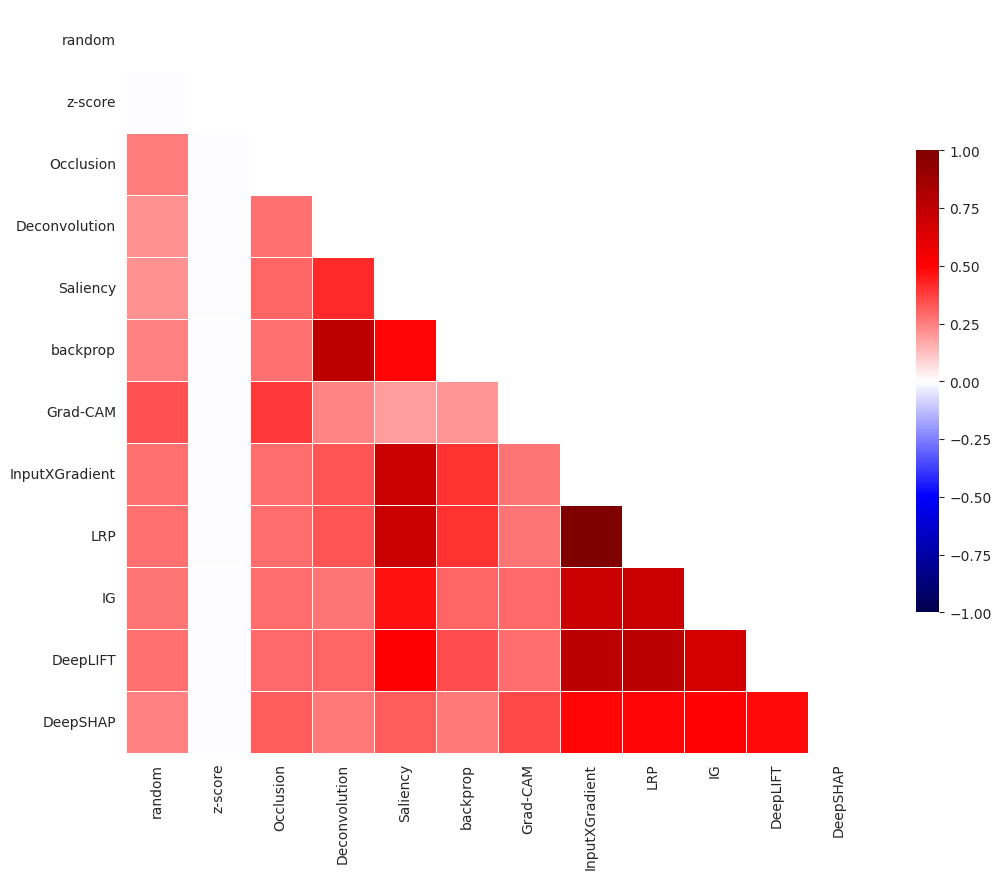

In [32]:
plot_corr(abs_pcorr, vmin=-1)
plt.savefig(osp.join(FIGURES_PATH, "abs_pcorr.png"), transparent=True, bbox_inches="tight")
plt.show()

In [33]:
# absolute spearman correlation

mu_class = [mu_ad, mu_cn]
sigma_class = [sigma_ad, sigma_cn]
corr = [0, 0]

for idx, (x,y) in enumerate(tqdm(test_ds)):
    for target in range(2):
        z = compute_z(x, mu_class[target], sigma_class[target]).abs()
        ams = load_attrib(idx, target)
        ams["z-score"] = z.unsqueeze(0).abs()
        ams["random"] = torch.normal(0,1,x.shape).abs()
        flattened = [am.abs().flatten().detach().numpy() for name, am in ams.items()]
        #corr[target] += np.corrcoef(np.array(flattened))
        corr[target] += spearmanr(np.array(flattened), axis=1).statistic
corr = np.array(corr)
corr /= len(test_ds)

  0%|          | 0/89 [00:00<?, ?it/s]

In [34]:
abs_scorr = (corr[0] + corr[1]) / 2

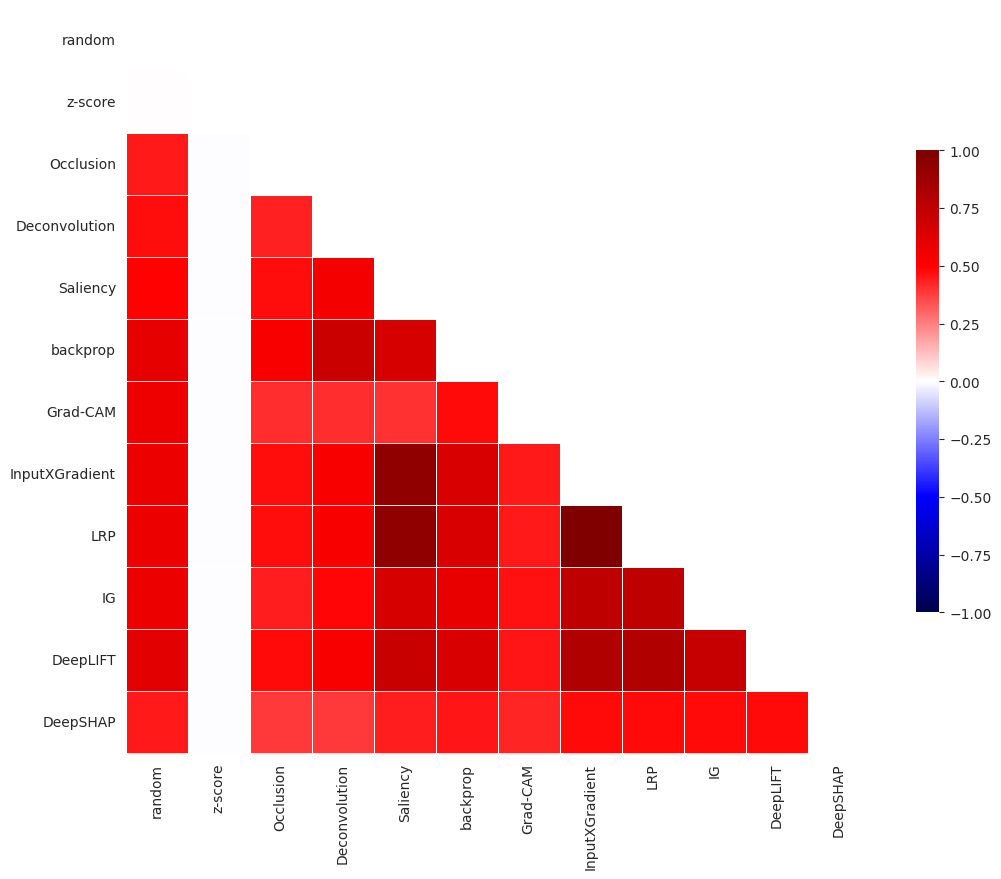

In [35]:
ax = plot_corr(abs_scorr, vmin=-1)
plt.savefig(osp.join(FIGURES_PATH, "abs_scorr.png"), transparent=True, bbox_inches="tight")
plt.show()

## 2. Deletion Metric

In [36]:
from cycler import cycler

COLORS = [
    "#555555", "#0000ff", "#ff0000", "#ff00ff",
    "#005500", "#0055ff", "#ff5500", "#ff55ff",
    "#00aa00", "#00aaff", "#ffaa00", "#ffaaff",
    "#00ff00", "#00ffff", "#ffff00"
]

#mpl.rcParams['axes.prop_cycle'] = cycler(color=COLORS)

LINE_STYLES = ["--", "-.", ":"]

color_cycler = cycler(color=COLORS)
ls_cycler = cycler(linestyle=5 * LINE_STYLES)
lw_cycler = cycler(linewidth=5 * [1,2,3])

score_cycler = color_cycler + ls_cycler + lw_cycler

In [37]:
def plot_scores(scores, x_plot):
    fig, ax = plt.subplots()
    ax.set_prop_cycle(score_cycler)
    for k, v in scores.items():
        mu_score = v.mean(0)
        # sigma_score = scores[name].std(0)
        ax.plot(x_plot, mu_score * 100, label=k)
        # plt.fill_between(x_plot, mu_score - sigma_score, mu_score + sigma_score, alpha=0.2)
    ax.set_yticks([10 * i for i in range(11)])
    ax.legend(loc="center left", bbox_to_anchor=(1.04, 0.5))
    ax.set_ylabel("Mean Predicted Probability (%)")
    ax.set_xlabel("Attribution Guided Perturbation (%)")
    ax.grid(True)
    return fig

In [64]:
def boxplot(scores, step=-1):
    fig, ax = plt.subplots()
    final = {}
    for k, v in scores.items():
        final[k] = (v[:,step] - v[:,0]) * 100
    
    ax.boxplot(final.values(), showfliers=False, labels=final.keys())
    ax.tick_params(axis='x', labelrotation = 90)
    ax.grid(axis="y")
    #plt.yticks([i * 10 for i in range(11)])
    ax.set_ylabel("Change in Predicted Probability (%)")
    return fig

In [39]:
def perturbation_test(model, am, x, base, target, steps, step_size=1, show_progress=False):
    """Iteratively replaces pixels in x with base according to their attribution."""
    _, topk = torch.topk(am.flatten(), steps * step_size)
    top_idxs = np.unravel_index(topk, am.shape)
    top_idxs = np.array(top_idxs)
    #top_idxs = np.column_stack(top_idxs)
    ys = []
    iterator = trange(steps + 1) if show_progress else range(steps + 1)
    for i in iterator:
        xd = x.clone().detach()
        xd[top_idxs[:,:i * step_size]] = base[top_idxs[:,:i * step_size]]
        with torch.no_grad():
            y = model(xd)[0][target]
        ys.append(y)
    return torch.tensor(ys), xd

In [40]:
base = torch.zeros(1,1,100,120,100)
voxels = int(0.05 * 100 * 120 * 100) # 5% perturbation
steps = 50
step_size = int(voxels / steps)
names = ["random"] + [name for (name,_,_) in METHODS]

scores = {n: [] for n in names}

for idx, (x, target) in enumerate(tqdm(test_ds)):
    if target == 1:
        continue
    x = x.unsqueeze(0)
    ams = load_attrib(idx, target)
    score = {}
    for key, am in ams.items():
        s, _ = perturbation_test(softmax_net, am, x, base, target, steps, step_size)
        scores[key].append(s)
    s, _ = perturbation_test(softmax_net, torch.rand(x.shape), x, base, target, steps)
    scores["random"].append(s)

del_cn_scores = { k: torch.stack(v) for k, v in scores.items()}

  0%|          | 0/89 [00:00<?, ?it/s]

TypeError: expected Tensor as element 0 in argument 0, but got tuple

In [50]:
torch.save(del_cn_scores, osp.join(AM_PATH, "del_cn_scores.p"))

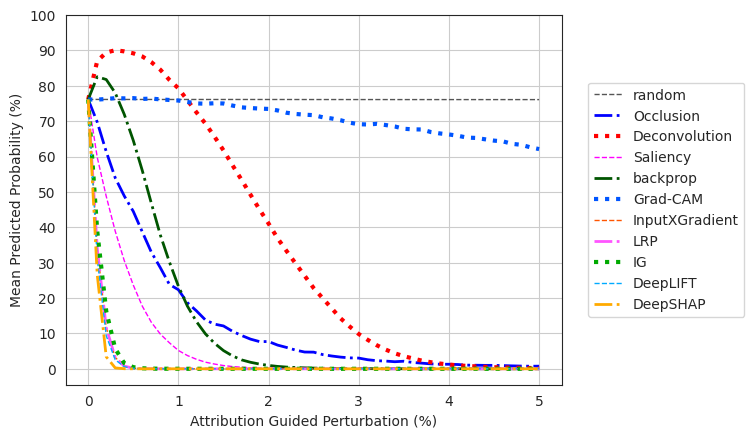

In [72]:
x_plot = np.linspace(0,5,steps+1)
plot_scores(del_cn_scores, x_plot)
plt.savefig(osp.join(FIGURES_PATH, "del_cn_scores.png"), transparent=True, bbox_inches="tight")
plt.show()

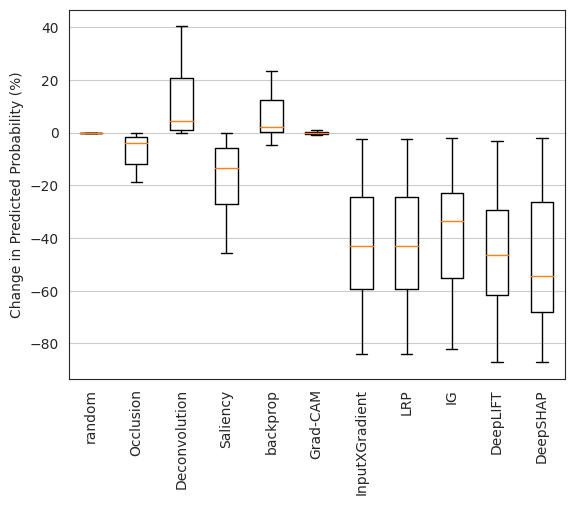

In [77]:
boxplot(del_cn_scores, step=1)
plt.savefig(osp.join(FIGURES_PATH, "del_cn_boxplot.png"), transparent=True, bbox_inches="tight")
plt.show()

In [51]:
base = torch.zeros(1,1,100,120,100)
voxels = int(0.05 * 100 * 120 * 100) # 5% perturbation
steps = 50
step_size = int(voxels / steps)
names = ["random"] + [name for (name,_,_) in METHODS]

scores = {n: [] for n in names}

for idx, (x, target) in enumerate(tqdm(test_ds)):
    if target == 0:
        continue
    x = x.unsqueeze(0)
    ams = load_attrib(idx, target)
    score = {}
    for key, am in ams.items():
        s, _ = perturbation_test(softmax_net, am, x, base, target, steps, step_size)
        scores[key].append(s)
    s, _ = perturbation_test(softmax_net, torch.rand(x.shape), x, base, target, steps)
    scores["random"].append(s)

del_ad_scores = { k: torch.stack(v) for k, v in scores.items()}

  0%|          | 0/89 [00:00<?, ?it/s]

TypeError: expected Tensor as element 0 in argument 0, but got tuple

In [345]:
torch.save(del_ad_scores, osp.join(AM_PATH, "del_ad_scores.p"))

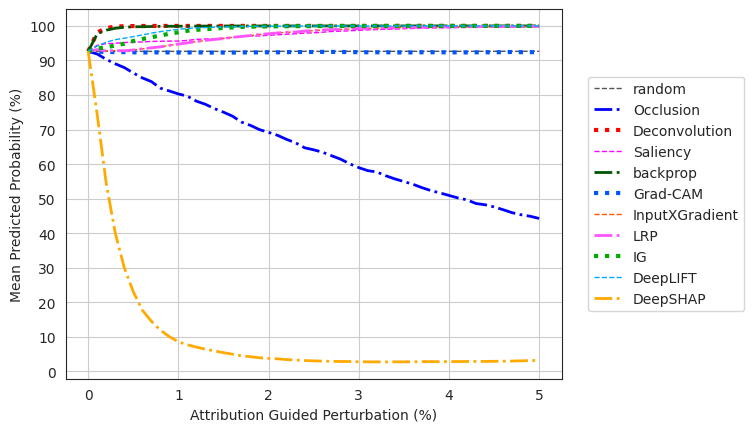

In [74]:
plot_scores(del_ad_scores, x_plot)
plt.savefig(osp.join(FIGURES_PATH, "del_ad_scores.png"), transparent=True, bbox_inches="tight")
plt.show()

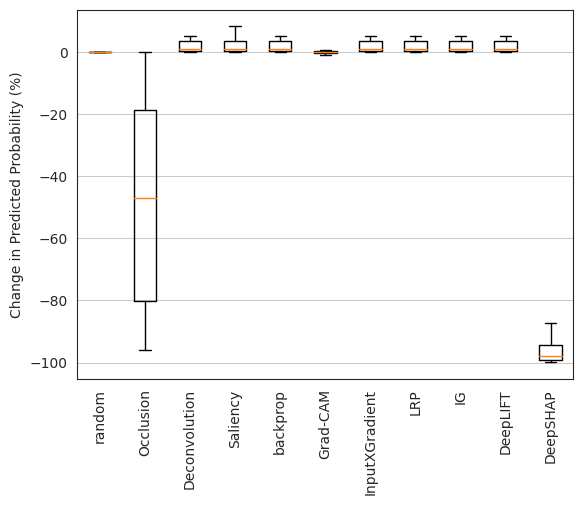

In [75]:
boxplot(del_ad_scores)
plt.savefig(osp.join(FIGURES_PATH, "del_ad_boxplot.png"), transparent=True, bbox_inches="tight")
plt.show()

- tbh: kind of unexpected
- this is probably because the model already predicts a black image as AD with about 75% probability
- so for example, voxels that received a high positive attribution from IG only contribute to the small increase from 75 to for example 90% anyway
- also, this contribution is determined, if all pixels are perturbed!
- there is no guarantee, that the probability won't go up in between

torch.Size([1, 1, 100, 120, 100])
Output for zero image tensor([[0.2570, 0.7430]], grad_fn=<SoftmaxBackward0>)
Output for demo input tensor([[0.0505, 0.9495]], grad_fn=<SoftmaxBackward0>)


/tmp/ipykernel_51429/2917211304.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print("Output for zero image", F.softmax(adni_net(base)))
/tmp/ipykernel_51429/2917211304.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print("Output for demo input", F.softmax(adni_net(x_demo)))
/home/bh282/.local/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

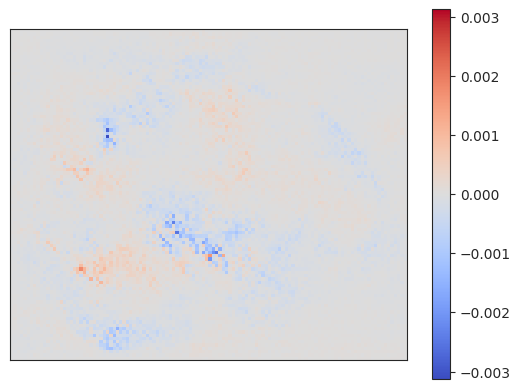

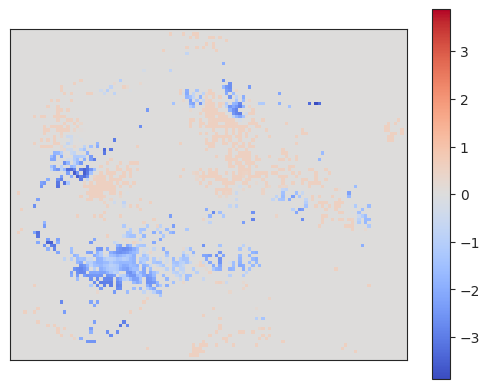

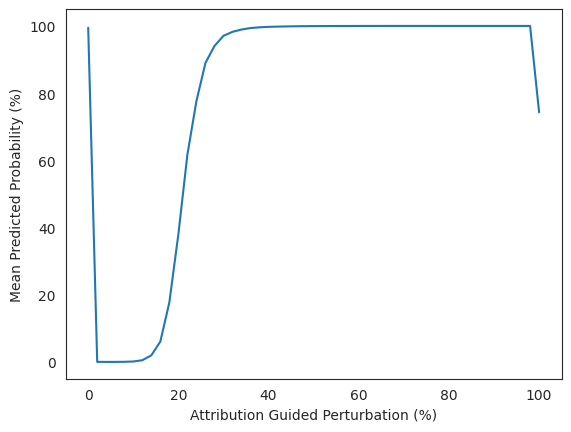

In [202]:
#base = tf_test(X_test[Y_test==0]).mean(0).unsqueeze(0)
#base = tf_test(torch.ones(1,1,100,120,100)*10)
base = torch.zeros(1,1,100,120,100)
random = base + torch.normal(0,1,(20,1,100,120,100))

# demonstration for first ad sample
x_demo = tf_test(X_test[51])
x_demo = x_demo.unsqueeze(0)

print(x_demo.shape)

print("Output for zero image", F.softmax(adni_net(base)))
print("Output for demo input", F.softmax(adni_net(x_demo)))


ds = DeepLiftShap(adni_net)
am = ds.attribute(x, target=1, baselines=random)

# show attribution
plt.figure()
im = plt.imshow(am.squeeze().detach().numpy()[30,:,:].T, origin="lower", cmap="coolwarm", norm=CenteredNorm())
plt.colorbar(im)
plt.xticks([])
plt.yticks([])
plt.savefig(osp.join(FIGURES_PATH, "demo_am.png"), transparent=True, bbox_inches="tight")

d = int(100*120*100 * 0.1) # show 40% perturbation first
steps = 50
step_size = int(d/steps)

_, xd = perturbation_test(softmax_net, am, x, base, target, steps, step_size, show_progress=True)

# show difference to 40% perturbed image
plt.figure()
im = plt.imshow((xd - x).squeeze().detach().numpy()[30,:,:].T, origin="lower", cmap="coolwarm", norm=CenteredNorm())
plt.colorbar(im)
plt.xticks([])
plt.yticks([])
plt.savefig(osp.join(FIGURES_PATH, "demo_dmap.png"), transparent=True, bbox_inches="tight")

d = int(100*120*100) # now up to 100% perturbation
steps = 50
step_size = int(d/steps)

y_preds, _ = perturbation_test(softmax_net, am, x, base, target, steps, step_size, show_progress=True)

# show probability

plt.figure()
plt.plot(np.linspace(0,100,steps+1), y_preds * 100)
plt.xlabel("Attribution Guided Perturbation (%)")
plt.ylabel("Mean Predicted Probability (%)")
plt.savefig(osp.join(FIGURES_PATH, "demo_p.png"), transparent=True, bbox_inches="tight")

#plt.xlim(0,100)
plt.show()

# Using a CN Reference

- therefore, should use a cn reference
- however, not applicable to every feature attribution method
- Occlusion, IG, DeepLIFT

In [181]:
cn_base = tf_test(X_train[Y_train==1]).mean(0).unsqueeze(0)
cn_random = cn_base + torch.normal(0,1,(20,1,100,120,100))

REF_FAMS = [
    # (Name, Captum Class, Additional Parameters)
    ("Occlusion", Occlusion(softmax_net), {"baselines": cn_base, "sliding_window_shapes": (1,20,20,20), "strides": 10}),
    ("IG", IntegratedGradients(softmax_net), {"baselines": cn_base}),
    ("DeepLIFT", DeepLift(softmax_net), {"baselines": cn_base}),
    ("DeepSHAP", DeepLiftShap(softmax_net), {"baselines": cn_random}),
]

NAMES = [n for n,_,_ in REF_FAMS]

In [182]:
cnref_ams = []

for idx, (x,y) in enumerate(tqdm(test_ds)):
    if y == 0:
        continue
    add_hooks(adni_net)
    ams = multi_attribute(REF_FAMS, x.unsqueeze(0), 1, interpolation=(100, 120, 100))
    cnref_ams.append(ams)
    fname = osp.join(AM_PATH, "cnref_{}.p".format(idx))
    torch.save(ams, fname)

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/home/bh282/.local/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/bh282/.local/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [188]:
rmean_ams = torch.zeros((4,1,100,120,100))

for ams in tqdm(cnref_ams):
    for i, fam in enumerate(NAMES):
        rmean_ams[i] += F.relu(ams[fam]).squeeze()

rmean_ams /= len(cnref_ams)
print(len(cnref_ams))

  0%|          | 0/38 [00:00<?, ?it/s]

38


In [189]:
rmean_ams = {n: rmean_ams[i] for i,n in enumerate(NAMES)}

In [190]:
def plot_row(axs, bg, am, cmap, norm, slices):
    """Plots a row of attribution maps."""
    x,y,z = slices
    lines = [(y,z), (x,z), (x,y)]
    axs[1].set_anchor("E")
    vmax = max(am[x,:,:].max(), am[:,y,:].max(), am[:,:,z].max())
    norm = CenteredNorm()
    for i, s in enumerate(slices):
        a = np.rollaxis(np.array(am), i, 0)
        b = np.rollaxis(np.array(bg), i, 0)
        axs[i].imshow(b[s,:,:].T, origin="lower", cmap="gray")
        im = axs[i].imshow(a[s, :, :].T, origin="lower", norm=norm, cmap=cmap, alpha=0.5)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].axvline(x=lines[i][0], linestyle=":", color="w", alpha=0.3)
        axs[i].axhline(y=lines[i][1], linestyle=":", color="w", alpha=0.3)
    
    plt.colorbar(im, ax=axs, pad=0.01)

def plot_amgrid(x, ams, fams, cmap="Spectral_r", norm=None):
    fig, axs = plt.subplots(len(fams),3, figsize=(7,2*len(fams)), width_ratios=(720,600,500))
    plt.subplots_adjust(wspace=0.15, hspace=0.15)

    for i, fam in enumerate(fams):
        axs[i,0].set_ylabel(fam)
        am = mean_ams[fam]
        if norm == "center":
            norm = CenteredNorm()
        plot_row(axs[i], mu_ad_test.squeeze(), am.squeeze(), cmap, norm, [30,55,35])

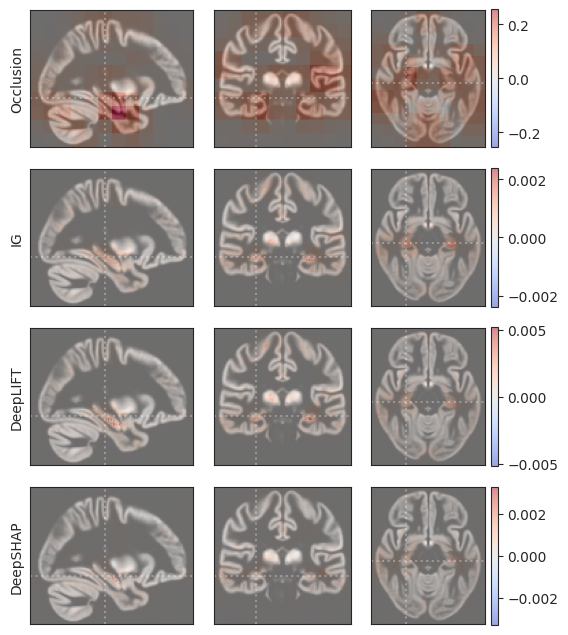

In [191]:
plot_amgrid(base, cnref_mean_ams, NAMES, "coolwarm", "center")
plt.savefig(osp.join(FIGURES_PATH, "cnref_ams.png"), transparent=True, bbox_inches="tight")
plt.show()

In [198]:
base = cn_base
voxels = int(0.05 * 100 * 120 * 100) # 5% perturbation
steps = 50
step_size = int(voxels / steps)
names = ["random"] + NAMES

scores = {n: [] for n in names}

for idx, (x, target) in enumerate(tqdm(test_ds)):
    if target == 0:
        continue
    x = x.unsqueeze(0)
    ams = torch.load(osp.join(AM_PATH, "cnref_{}.p".format(idx)))
    score = {}
    for key, am in ams.items():
        s, _ = perturbation_test(softmax_net, am, x, base, target, steps, step_size)
        scores[key].append(s)
    s, _ = perturbation_test(softmax_net, torch.rand(x.shape), x, base, target, steps)
    scores["random"].append(s)

del_cnref_scores = { k: torch.stack(v) for k, v in scores.items()}

  0%|          | 0/89 [00:00<?, ?it/s]

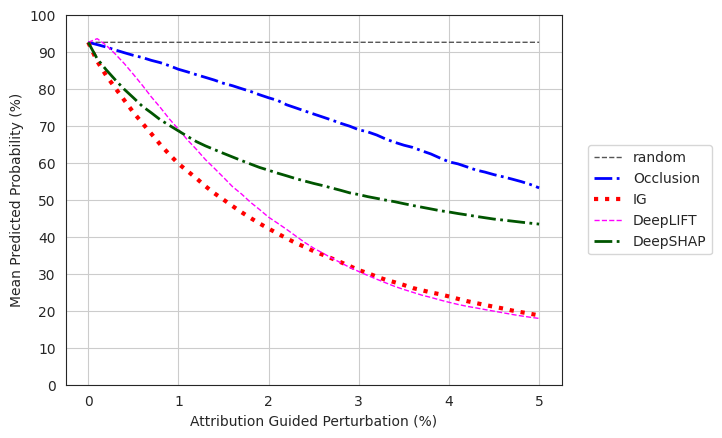

In [199]:
plot_scores(del_cnref_scores, x_plot)
plt.savefig(osp.join(FIGURES_PATH, "del_cnref_scores.png"), transparent=True, bbox_inches="tight")
plt.show()

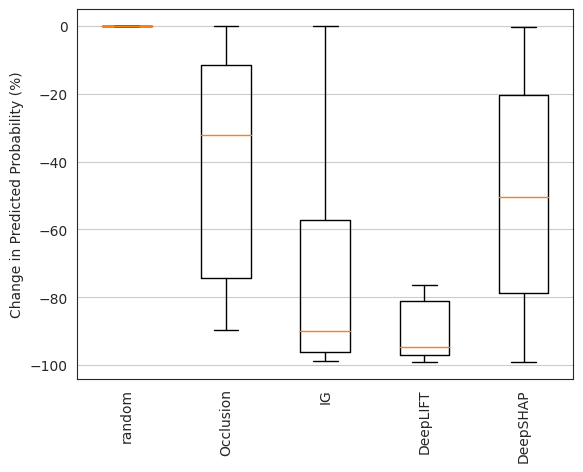

In [200]:
boxplot(del_cnref_scores)
plt.savefig(osp.join(FIGURES_PATH, "del_cnref_boxplot.png"), transparent=True, bbox_inches="tight")
plt.show()

## 3. Conversion Metric

In [138]:
base = torch.zeros(1,1,100,120,100)
scores = []
voxels = int(0.05 * 100 * 120 * 100)
steps = 50
step_size = int(voxels / steps)
names = [name for (name,_,_) in METHODS] + ["random"]

for (x, label) in tqdm(test_ds):
    x = x.unsqueeze(0)
    target = (label + 1) % 2
    attrib_cn = load_attrib(idx, 0)
    attrib_ad = load_attrib(idx, 1)
    score = {}
    for name in attrib_cn.keys():
        attrib = attrib_cn[name] - attrib_ad[name]
        if label == 1:
            attrib *= -1
        score[name] = pertubation_test(softmax_net, attrib, x, base, target, steps, step_size)
    score["random"] = pertubation_test(softmax_net, torch.rand(x.shape), x, base, target, steps)
    scores.append(score)

conv_scores = { name: torch.stack([s[name] for s in scores]) for name in names}

  0%|          | 0/89 [00:00<?, ?it/s]

NameError: name 'pertubation_test' is not defined

In [ ]:
torch.save(conv_scores, osp.join(ATTRIB_PATH, "conv_scores.p"))

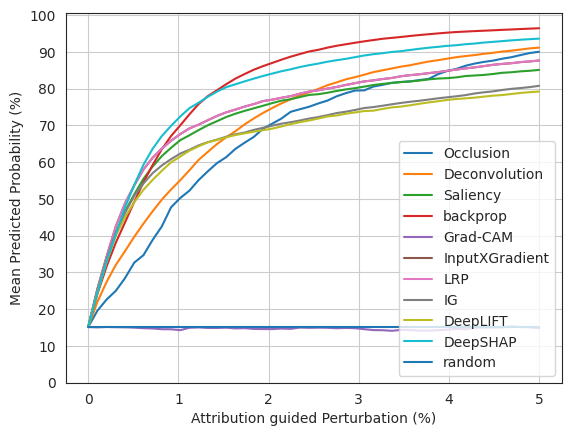

In [43]:
xdata = np.linspace(0, 5, 50)

for name in names:
    vmu = conv_scores[name].mean(0)[:50] * 100
    plt.plot(xdata, vmu, label=name)

plt.yticks([10 * i for i in range(11)])
plt.legend(loc=1)
plt.ylabel("Mean Predicted Probability (%)")
plt.xlabel("Attribution guided Perturbation (%)")
plt.grid(True)
plt.legend()

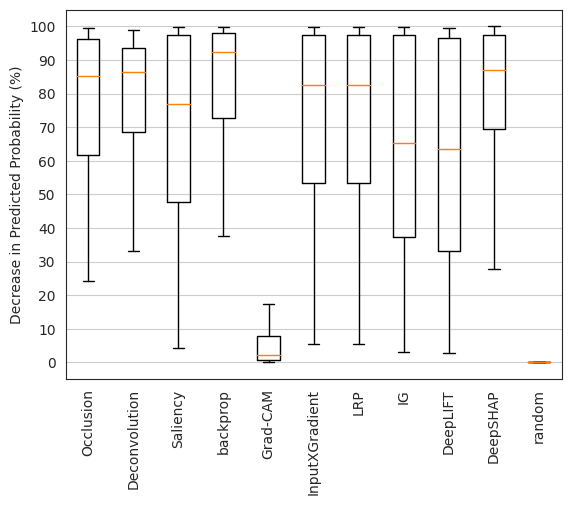

In [116]:
final = {}
for name in conv_scores.keys():
    final[name] = abs(conv_scores[name][:,10] - conv_scores[name][:,0]) * 100

plt.boxplot(final.values(), showfliers=False, labels=final.keys())
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.yticks([i * 10 for i in range(11)])
plt.ylabel("Decrease in Predicted Probability (%)")
plt.show()

## 4. Robustness

Compare Mean Attribution Maps across k-Fold.

See Eitel and Ritter: *Testing the robustness of attribution methods for convolutional neural networks in MRI-based Alzheimer’s disease classification*.

In [140]:
# for each kfold model
# compute mean attribution maps
# register to nilearn aal template
# compute most relevant brain regions per method
# compare robustness of most relevant models per method and model run

In [97]:
def build_methods(model, base):
    softmax_model = nn.Sequential(model, nn.Softmax(1))
    softmax_model.eval()
    random = torch.normal(0,1,(20, 1, 100, 120, 100))
    
    methods = [
        # (Name, Captum Class, Additional Parameters)
        ("Occlusion", Occlusion(model), {"baselines": base, "sliding_window_shapes": (1,20,20,20), "strides": 10}),
        ("Deconvolution", Deconvolution(model), {}),
        ("Saliency", Saliency(model), {"abs": False}), # has keyword abs, if False returns the signed Gradient
        ("backprop", GuidedBackprop(model), {}),
        ("Grad-CAM", LayerGradCam(softmax_model, model.cb3.conv3d), {"relu_attributions": False}),
        ("InputXGradient", InputXGradient(model), {}),
        ("LRP", LRP(model), {}),
        ("IG", IntegratedGradients(model), {"baselines": base}),
        ("DeepLIFT", DeepLift(model), {"baselines": base}),
        ("DeepSHAP", DeepLiftShap(model), {"baselines": random}),
    ]
    
    return methods

In [101]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random.RandomState(19))
mean_attribs = []
kfold_dir = osp.join(ATTRIB_PATH, "kfold")
os.makedirs(kfold_dir, exist_ok=True)

pbar = tqdm(total=5)
for i, (train_idxs, test_idxs) in enumerate(skf.split(X, Y)):
    knet = AdniNet()
    knet.load_state_dict(torch.load(osp.join(MODEL_PATH, "kfold-{}.pt".format(i))))
    knet.eval()
    
    X_k = X[test_idxs]
    Y_k = Y[test_idxs]
    X_kad = X_k[Y_k == 1]
    Y_kad = Y_k[Y_k == 1]
    kds = TransformTensorDataset(X_kad, Y_kad, transform=tf_test)
    
    methods = build_methods(knet, base)
    n = 0
    mean_attrib = {name: 0 for (name,_,_) in methods}
    
    for idx, (x, y) in enumerate(kds):
        add_hooks(knet)
        a = multi_attribute(methods, x.unsqueeze(0), 1, interpolation=(100,120,100))
        aname = osp.join(kfold_dir, "kfold-{}_idx-{}.p".format(i, idx))
        torch.save(a, aname)
        for name,_,_ in methods:
            mean_attrib[name] += a[name]
        n+= 1
    
    for name,_,_ in methods:
        mean_attrib[name] /= n
    mean_attribs.append(mean_attrib)
    pbar.update()
pbar.close()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/home/bh282/.local/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/bh282/.local/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/bh282/.local/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [233]:
mean_attribs = []

for i in range(5):
    n = 0
    amean = {name: 0 for name,_,_ in METHODS}
    for aname in glob.glob(osp.join(kfold_dir, "kfold-{}_idx-*".format(i))):
        attrib = torch.load(aname)
        for name, a in attrib.items():
            amean[name] += F.relu(a)
        n += 1
    for name in amean.keys():
        amean[key] /= n
    mean_attribs.append(amean)

In [272]:
# compute sum of l2 norm between all attributions
# normalize each attribution by max value

l2_dist = {name: 0 for name,_,_ in METHODS}
indices = [(i,j) for i in range(5) for j in range(i+1,5)]

def maxnorm(a):
    a = a.clone().detach()
    m = abs(a).max()
    if m != 0:
        a /= m
    return a

for i,j in indices:
    for name,_,_ in METHODS:
        a1 = maxnorm(mean_attribs[i][name])
        a2 = maxnorm(mean_attribs[j][name])
        l2_dist[name] += torch.norm(a2 - a1, 2).item()

In [273]:
l2_dist

{'Occlusion': 1100.0492935180664,
 'Deconvolution': 418.0290107727051,
 'Saliency': 469.6206817626953,
 'backprop': 408.86423683166504,
 'Grad-CAM': 2342.029228210449,
 'InputXGradient': 248.2903289794922,
 'LRP': 248.29033660888672,
 'IG': 263.3687365900653,
 'DeepLIFT': 238.50182342529297,
 'DeepSHAP': 311.6458988189697}

## 6. Top Relevant Regions

In [172]:
from nilearn.datasets import fetch_atlas_aal
from nilearn.image import resample_to_img

target_img = nib.load(glob.glob("data/AD/*.nii.gz")[0])
aal_data = fetch_atlas_aal(data_dir="data/")
aal_img = nib.load(aal_data.maps)
aal_img = resample_to_img(aal_img, target_img, interpolation="nearest")
aal = crop(torch.tensor(aal_img.get_fdata()).unsqueeze(0))

In [177]:
def relevance_by_region(attrib, norm=True):
    """Compute the density of relevance for each AAL Atlas region."""
    regions = {}
    for idx, label in zip(aal_data.indices, aal_data.labels):
        mask = (aal == int(idx))
        r = (attrib * mask).sum()
        if norm:
            r /= mask.sum()
        regions[label] = r.item()
    return regions

def multi_regions(attribs, norm):
    """Compute relevance by region for multiple attribution methods."""
    regions = {}
    for name in attribs.keys():
        r = relevance_by_region(attribs[name], norm)
        r = sorted(r.items(), key=lambda item: item[1], reverse=True)
        regions[name] = r
    return regions

In [192]:
mrs = multi_regions(cnref_mean_ams, norm=True)
for n,r in mrs.items():
    print(n)
    for i in range(100):
        print("{}. {}".format(i+1, r[i][0]))
    print("")

Occlusion
1. Supp_Motor_Area_L
2. Supp_Motor_Area_R
3. Rolandic_Oper_L
4. Cingulum_Mid_L
5. Cingulum_Mid_R
6. Paracentral_Lobule_R
7. Precuneus_L
8. Precuneus_R
9. Heschl_L
10. Frontal_Med_Orb_R
11. Cingulum_Post_R
12. Frontal_Med_Orb_L
13. Postcentral_L
14. Rolandic_Oper_R
15. Paracentral_Lobule_L
16. Postcentral_R
17. Temporal_Sup_L
18. Frontal_Sup_Medial_R
19. Insula_L
20. Cingulum_Post_L
21. Thalamus_R
22. Cingulum_Ant_R
23. Frontal_Sup_Medial_L
24. Cingulum_Ant_L
25. SupraMarginal_L
26. Precentral_L
27. Cerebelum_9_L
28. Heschl_R
29. Thalamus_L
30. Frontal_Inf_Oper_L
31. Cerebelum_8_L
32. Insula_R
33. Precentral_R
34. Cerebelum_9_R
35. Temporal_Pole_Sup_R
36. Parietal_Sup_R
37. Temporal_Sup_R
38. Temporal_Pole_Sup_L
39. Frontal_Sup_L
40. Cerebelum_8_R
41. Frontal_Sup_Orb_L
42. SupraMarginal_R
43. Putamen_R
44. Frontal_Sup_Orb_R
45. Cerebelum_7b_L
46. Pallidum_R
47. Parietal_Inf_L
48. Hippocampus_R
49. Putamen_L
50. Rectus_R
51. Amygdala_L
52. Vermis_9
53. Amygdala_R
54. Frontal_Su

In [179]:
mrs = multi_regions(cnref_mean_ams, norm=False)
for n,r in mrs.items():
    print(n)
    for i in range(100):
        print("{}. {}".format(i+1, r[i][0]))
    print("")

Occlusion
1. Precuneus_L
2. Precuneus_R
3. Postcentral_L
4. Supp_Motor_Area_L
5. Supp_Motor_Area_R
6. Postcentral_R
7. Precentral_L
8. Cingulum_Mid_R
9. Frontal_Sup_Medial_L
10. Cingulum_Mid_L
11. Temporal_Sup_L
12. Precentral_R
13. Frontal_Sup_L
14. Frontal_Sup_Medial_R
15. Temporal_Sup_R
16. Insula_L
17. Frontal_Sup_R
18. Rolandic_Oper_L
19. Rolandic_Oper_R
20. Temporal_Mid_L
21. Paracentral_Lobule_L
22. Parietal_Sup_R
23. Cerebelum_8_L
24. Cingulum_Ant_R
25. Cingulum_Ant_L
26. Cerebelum_8_R
27. Insula_R
28. Paracentral_Lobule_R
29. Parietal_Inf_L
30. SupraMarginal_L
31. Frontal_Med_Orb_R
32. Thalamus_R
33. SupraMarginal_R
34. Cerebelum_Crus1_R
35. Temporal_Pole_Sup_R
36. Frontal_Med_Orb_L
37. Thalamus_L
38. Frontal_Mid_L
39. Temporal_Mid_R
40. Parietal_Sup_L
41. Frontal_Inf_Oper_L
42. Temporal_Pole_Sup_L
43. Calcarine_L
44. Cerebelum_9_L
45. Frontal_Inf_Orb_L
46. Frontal_Inf_Tri_L
47. Lingual_R
48. Cerebelum_Crus2_L
49. Cerebelum_Crus1_L
50. Cerebelum_9_R
51. Cuneus_R
52. Cuneus_L
5

In [197]:
mrs = multi_regions(cnref_mean_ams, norm=False)
print("& " + " & ".join(mrs.keys()))

for i in range(10):
    rs = list(mrs.values())
    print(str(i+1) + ". & " + " & ".join([r[i][0] for r in rs[:]]) + " \\\\")
    

& Occlusion & IG & DeepLIFT & DeepSHAP
1. & Precuneus_L & Temporal_Mid_L & Temporal_Mid_L & Calcarine_L \\
2. & Precuneus_R & Temporal_Mid_R & Temporal_Mid_R & Precentral_R \\
3. & Postcentral_L & Temporal_Inf_L & Temporal_Inf_L & Calcarine_R \\
4. & Supp_Motor_Area_L & Precentral_R & Precuneus_R & Cerebelum_6_R \\
5. & Supp_Motor_Area_R & Postcentral_L & Precuneus_L & Precentral_L \\
6. & Postcentral_R & Frontal_Mid_L & Temporal_Inf_R & Lingual_L \\
7. & Precentral_L & Postcentral_R & Parietal_Inf_L & Postcentral_R \\
8. & Cingulum_Mid_R & Hippocampus_L & Frontal_Mid_L & Postcentral_L \\
9. & Frontal_Sup_Medial_L & Temporal_Inf_R & Hippocampus_L & Lingual_R \\
10. & Cingulum_Mid_L & Parietal_Inf_L & Supp_Motor_Area_R & Cuneus_L \\


In [356]:
 = list(mrs.items())

ValueError: too many values to unpack (expected 3)

In [335]:
print("test")

test


In [289]:
kregions = []

for i, attrib in enumerate(mean_attribs):
    regions = multi_regions(attrib)
    kregions.append(regions)

In [291]:
names = [name for name, _,_ in METHODS]

In [325]:
ktop10 = {name: np.array([[label for label, _ in kr[name][:10]] for kr in kregions]) for name in names}
intersection = {name: {label: (top10 == label).sum() for label in np.unique(top10)} for name, top10 in ktop10.items()}

In [327]:
consistency = {name: sum([n == 5 for l, n in inter.items()]) / 10 for name, inter in intersection.items()}
consistency

{'Occlusion': 0.4,
 'Deconvolution': 0.1,
 'Saliency': 0.1,
 'backprop': 0.2,
 'Grad-CAM': 0.0,
 'InputXGradient': 0.2,
 'LRP': 0.2,
 'IG': 0.2,
 'DeepLIFT': 0.2,
 'DeepSHAP': 0.0}

(<Figure size 600x200 with 3 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

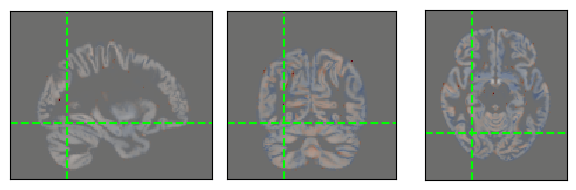

In [398]:
plot_slices(x, 40, 40, 40, attr=z, alpha=0.5)

(<Figure size 600x200 with 3 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

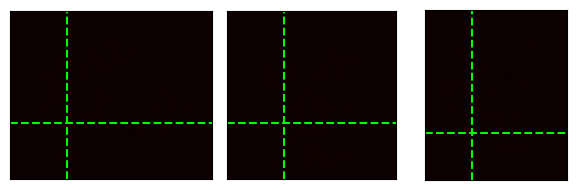

In [406]:
plot_slices(z, 40,40,40, cmap="hot")

/tmp/ipykernel_35149/2834737973.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


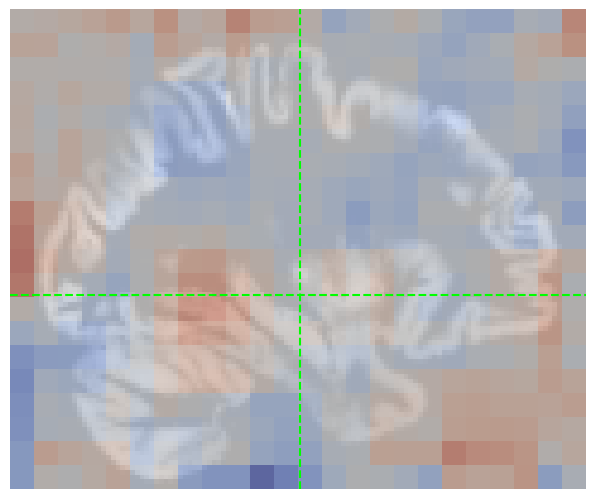

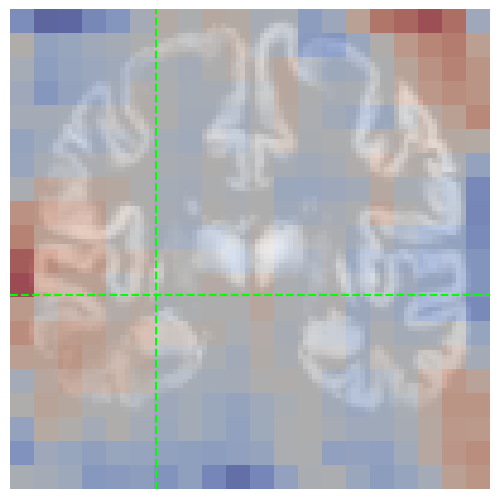

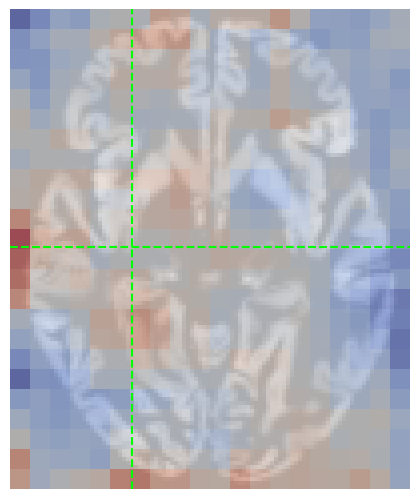

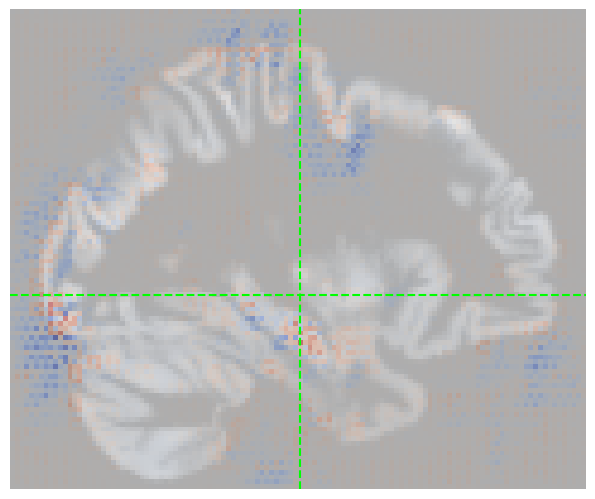

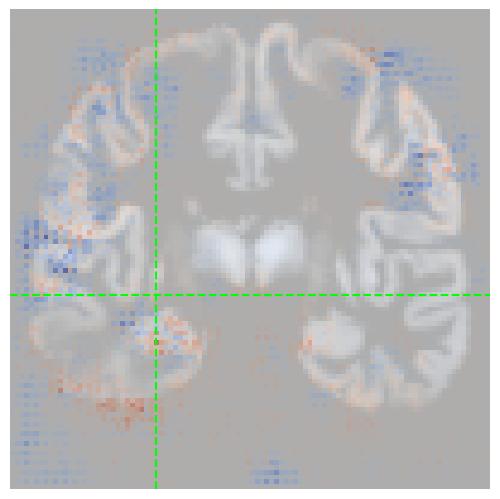

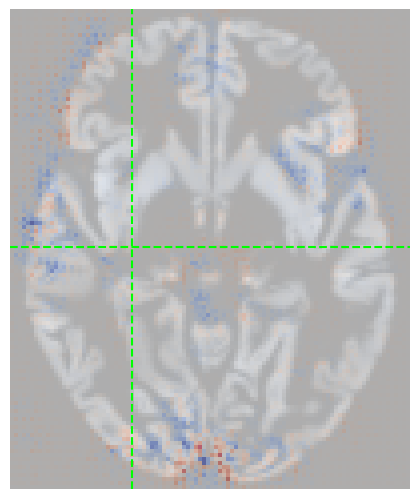

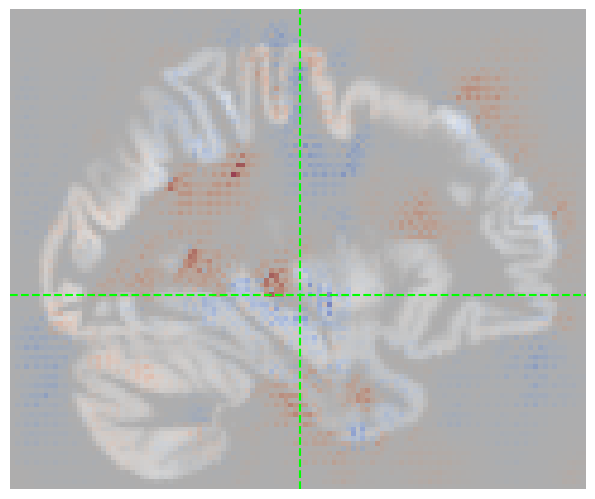

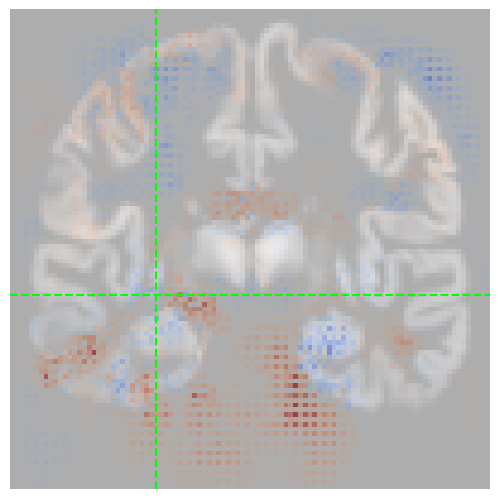

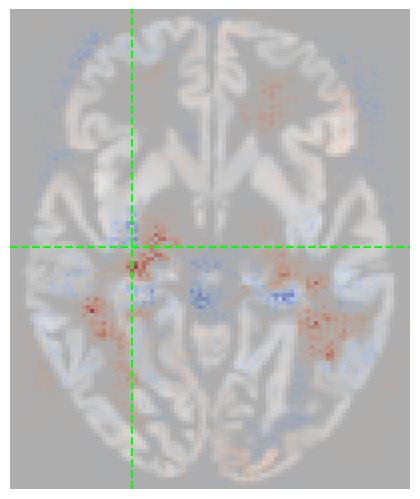

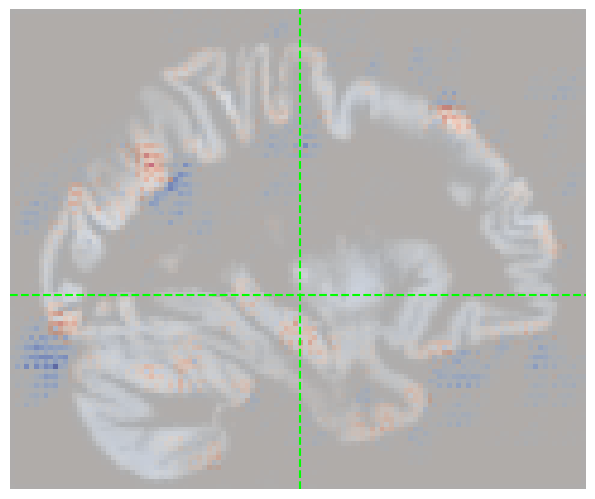

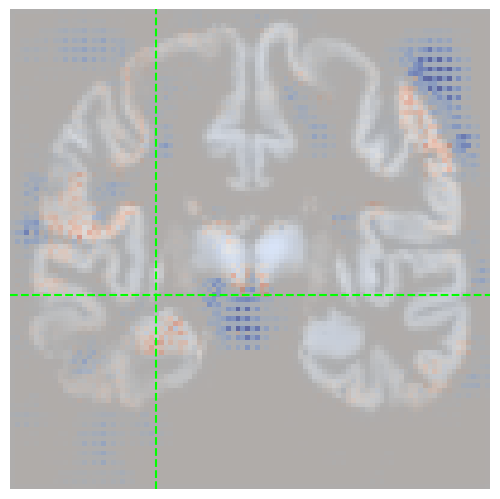

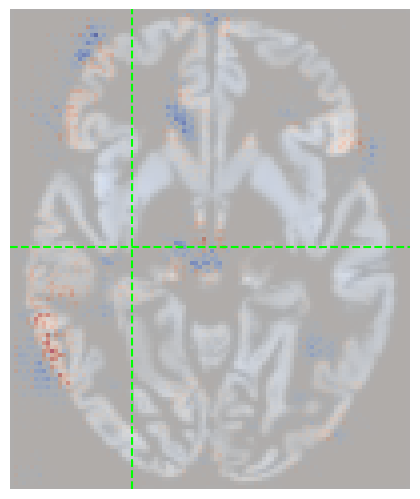

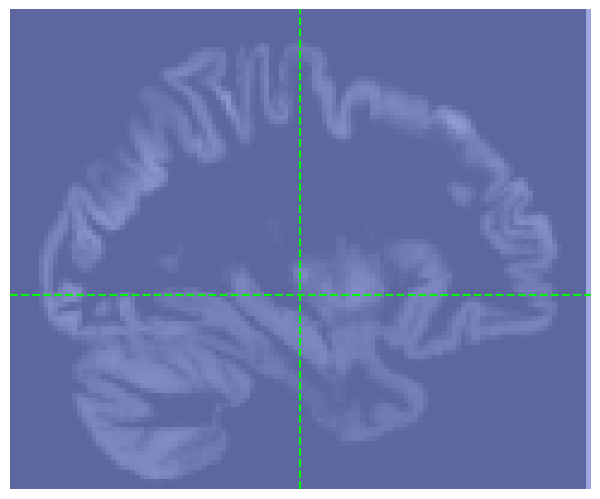

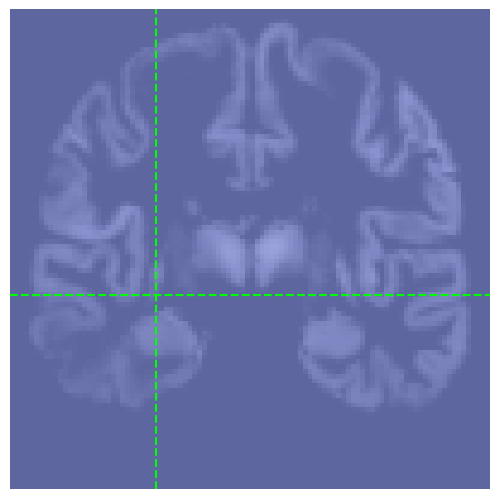

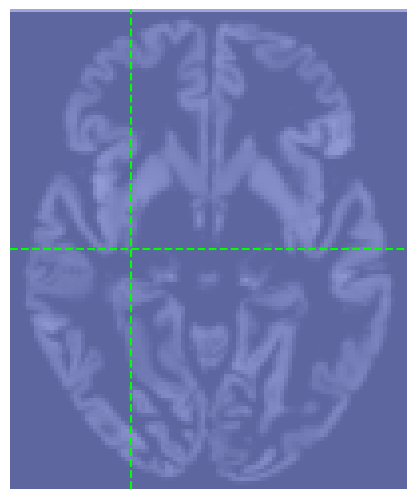

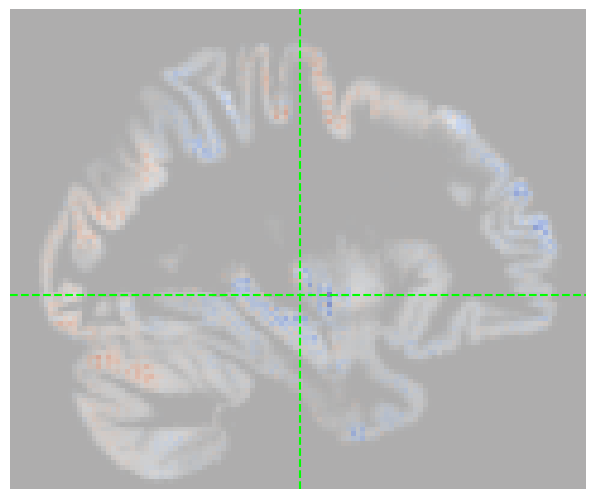

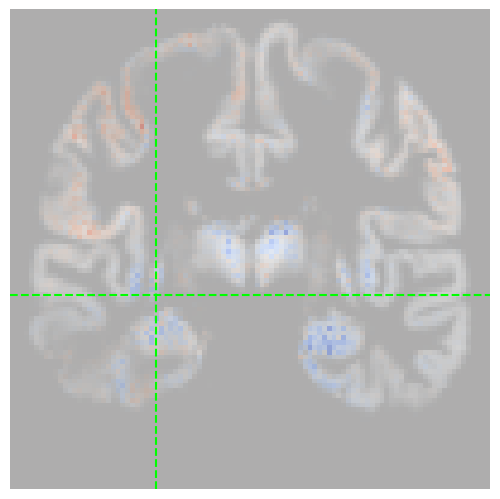

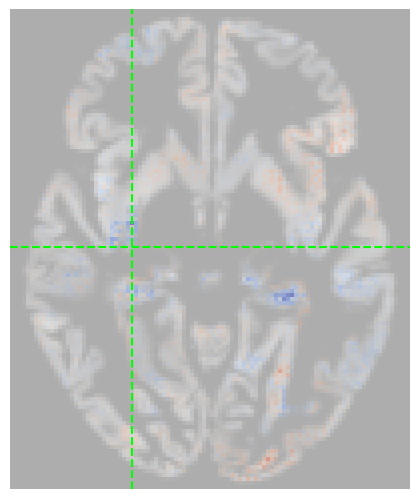

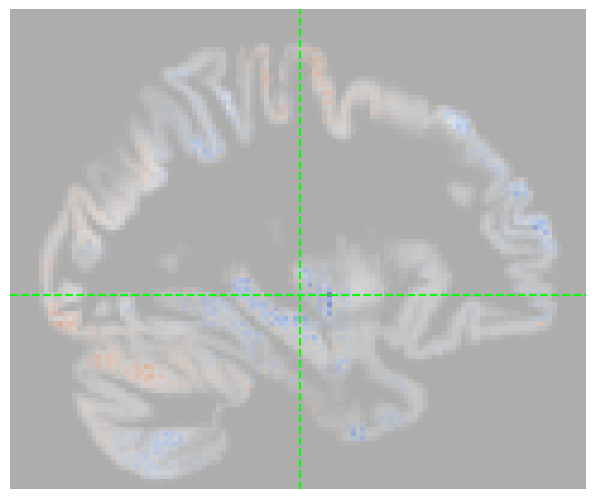

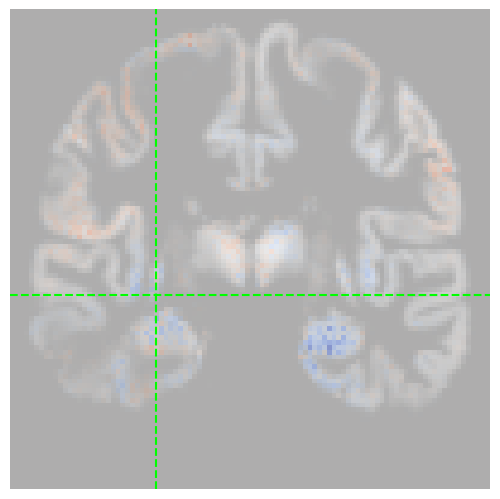

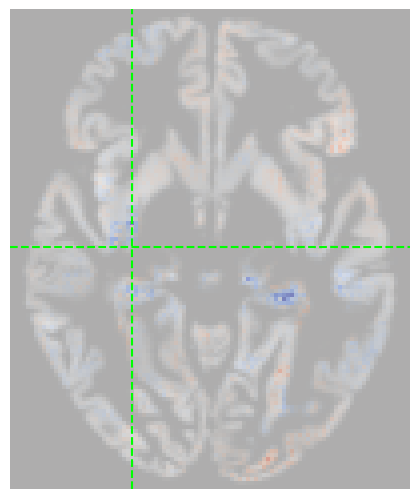

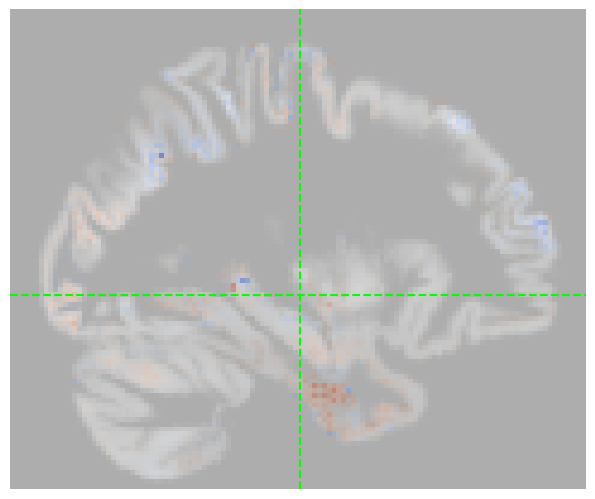

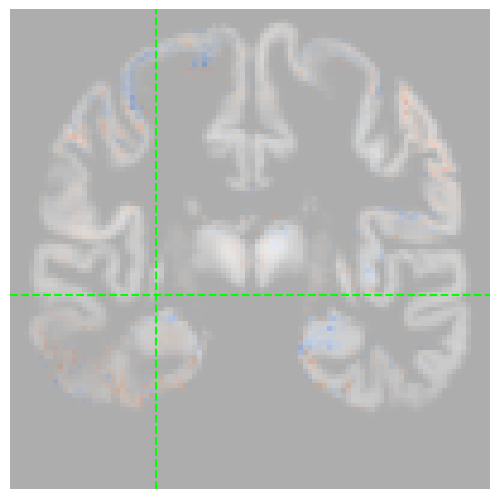

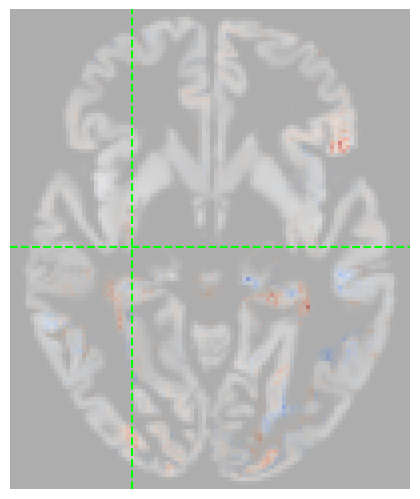

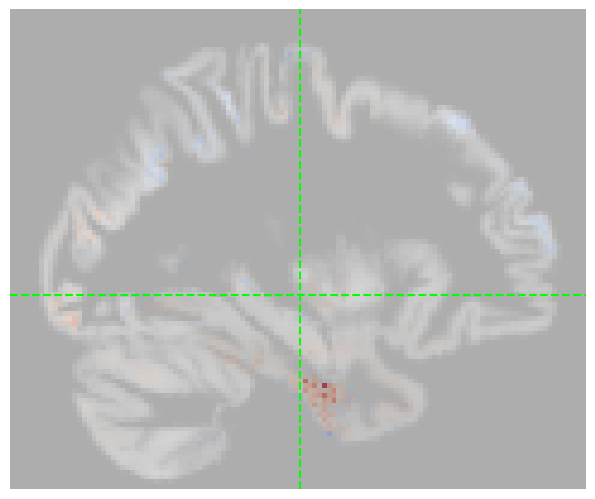

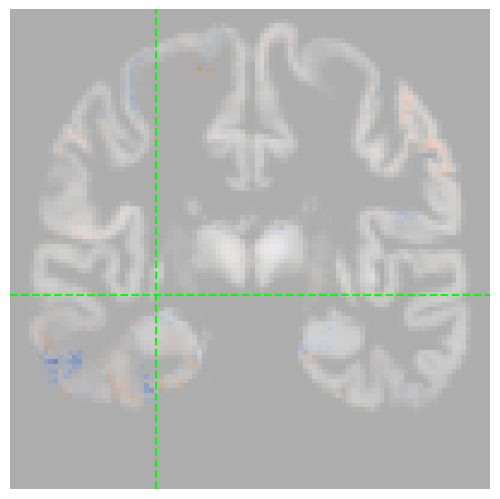

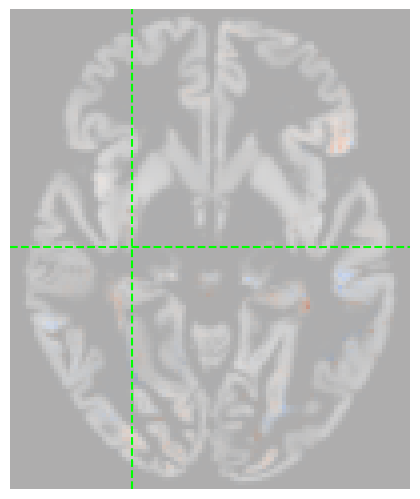

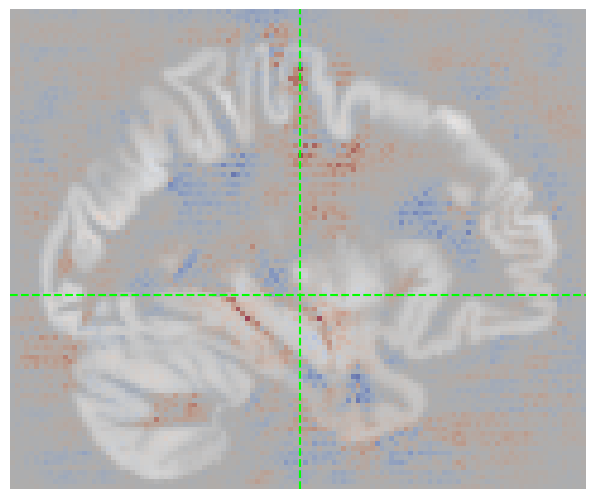

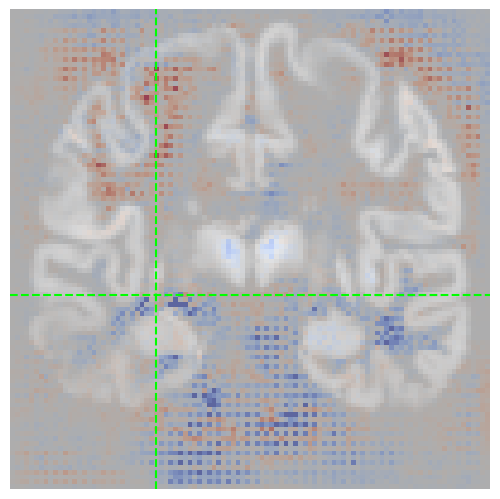

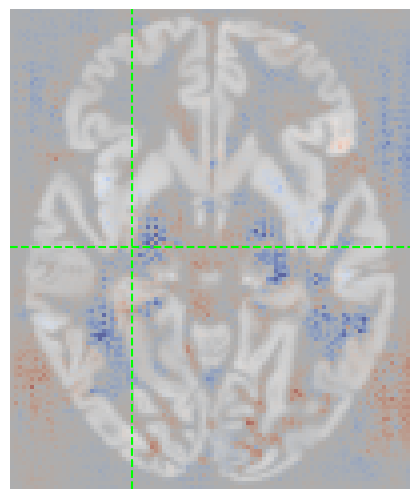

In [228]:
save_attributions("figures", transform_test(X_test[2]), attr, 30, 60, 40)